# Wireless Channel Generation for Multiple Carrier Frequencies


* In this tutorial, we will analyze the performance of channel Model at multiple carrier frequencies under the propagation scenario Urban Macro or "UMa" for a Hexagonal Base Station (BS) Layout.
* For a given number of BSs and UEs we generate multi-frequency cluster level channel coefficients corresponding to every link being simulated. 

* We first import the necessary libraries then followed by creating objects of classes `AntennaArrays`, `NodeMobility`, and `SimulationLayout` respectively.

The content of the tutorial is as follows:

**Table of Contents**

* [Import Libraries](#Import-Libraries)
    - [Python Libraries](#Python-Libraries)
    - [5G Toolkit Libraries](#5G-Toolkit-Libraries)
* [Simulation Parameters](#Simulation-Parameters)
* [Generate Antenna Arrays](#Generate-Antenna-Array)
* [Node Mobility/Route](#Node-Mobility)
* [Generate Simulation Topology](#Generate-Simulation-Layout)
* [Generate Channel(LSP/SSPs) Parameters](#Generate-Channel-Parameters)
* [Generate Channel Coefficients](#Generate-Channel-Coefficients)
* [Generate OFDM Channel Generation](#Generate-OFDM-Channel)
    - [Frequency Domain: Magnitude Response Plot](#Frequency-Domain-:-Magnitude-Response-Plot)
    - [Time Domain Channel Response](#Time-Domain-Channel-response)

## Import Libraries
### Python Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy      as np

### 5G Toolkit Libraries

In [2]:

from toolkit5G.ChannelModels import NodeMobility
from toolkit5G.ChannelModels import AntennaArrays
from toolkit5G.ChannelModels import SimulationLayout
from toolkit5G.ChannelModels import ParameterGenerator
from toolkit5G.ChannelModels import ChannelGenerator


## Simulation Parameters

The simulation parameters are defined as follows
  * ``propTerrain`` defines propagation scenario or terrain for BS-UE, UE-UE, BS-BS links
  * ``carrierFrequency`` defines  array of carrier frequencies in GHz
  * ``nBSs`` defines number of Base Stations (BSs)
  * ``nUEs`` defines number of User Equipments (UEs) 
  * ``nSnapShots`` defines number of SnapShots

In [3]:
# Simulation Parameters
propTerrain      = "UMa"                          # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = np.array([3*10**9, 28*10**9])  # Array of two carrier frequencies in Hz
nBSs             = 21                             # number of BSs
nUEs             = 50                             # number of UEs 
nSnapShots       = 5                             # number of SnapShots

## Generate Antenna Array

**Antenna Arrays for UEs**

The following steps describe the procedure to simulate AntennaArrays Objects at a single carrier frequency
both at Tx and Rx side:

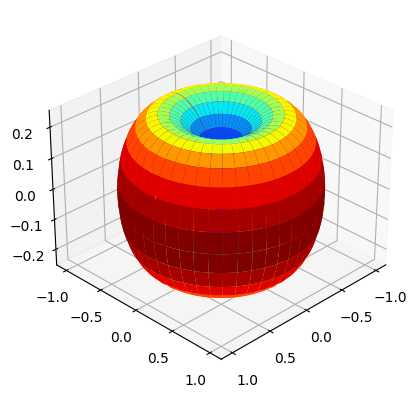

(<Figure size 960x480 with 1 Axes>, <Axes3D: >)

In [4]:
# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
numCarriers = carrierFrequency.shape[0]
ueAntArray  = np.empty(numCarriers, dtype=object)
for i in range(carrierFrequency.size):
    ueAntArray[i] = AntennaArrays(antennaType     = "OMNI", 
                                  centerFrequency = carrierFrequency[i],
                                  arrayStructure  = np.array([1,1,1,2,1]))
    ueAntArray[i]() 
# Radiation Pattern of Rx antenna element 
ueAntArray[0].displayAntennaRadiationPattern()    

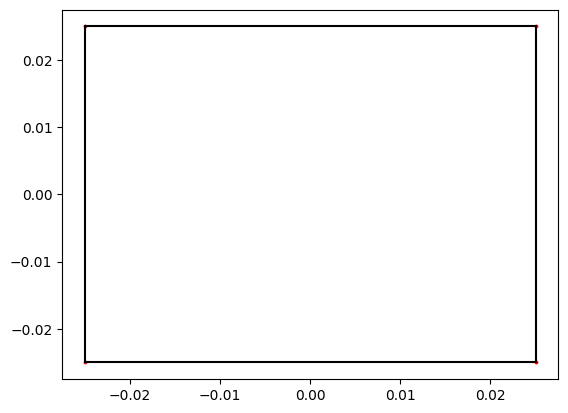

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [5]:
ueAntArray[0].displayArray("2D")

**Antenna Arrays for BS**

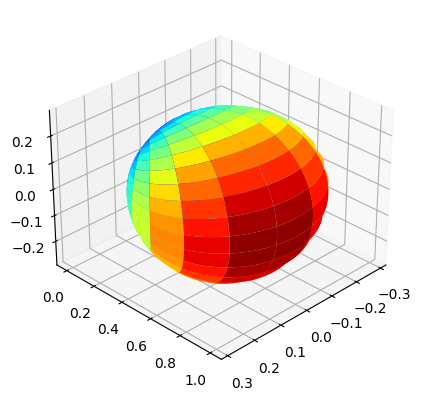

(<Figure size 960x480 with 1 Axes>, <Axes3D: >)

In [6]:
# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.
numCarriers    = carrierFrequency.shape[0]
bsAntArray     = np.empty(numCarriers, dtype=object)
for i in range(carrierFrequency.size):
    bsAntArray[i] = AntennaArrays(antennaType     = "3GPP_38.901", 
                                  centerFrequency = carrierFrequency[i],
                                  arrayStructure  = np.array([1,1,2,4,1]))
    bsAntArray[i]()
# Radiation Pattern of Tx antenna element 
bsAntArray[0].displayAntennaRadiationPattern()    

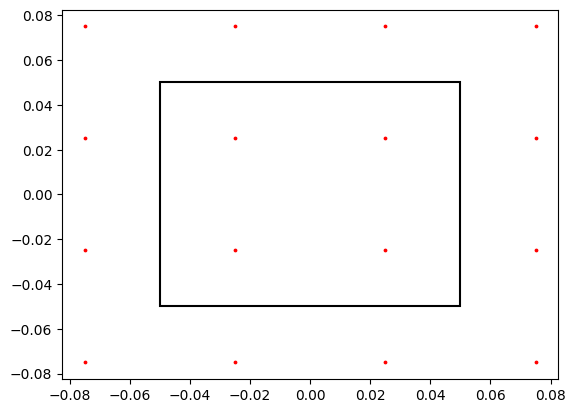

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [7]:
bsAntArray[0].displayArray("2D")

## Node Mobility

This subsection provides the following steps to simulate the mobility of each node

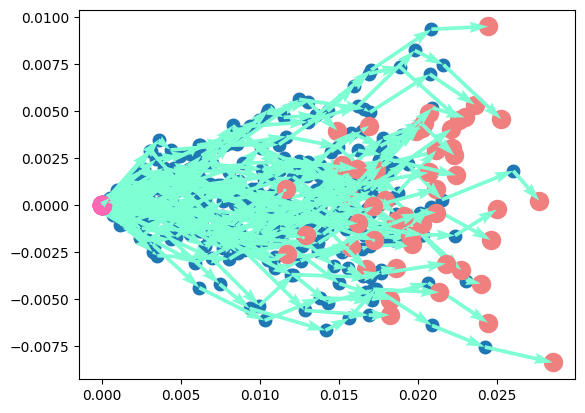

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [8]:
# NodeMobility parameters
# assuming that all the BSs are static and all the UEs are mobile.
interval = 10*0.5*10**-3/nSnapShots
timeInst = np.arange(nSnapShots, dtype=np.float32)*interval  # time values at each snapshot.
UEroute  = NodeMobility("randomWalk", nUEs, timeInst, 0, 10)
UEroute.displayRoute()

## Generate Simulation Layout

We define the simulation topology parametes:

 - ``ISD``: Inter Site Distance
 - ``minDist``: Minimum distance between transmitter and receiver.
 - ``bsHt``: BS heights 
 - ``ueHt``: UE heights
 - ``topology``: Simulation Topology
 - ``nSectorsPerSite``: Number of Sectors Per Site
 
Furthermore, users can access and update following parameters as per their requirements for channel using the handle simLayoutObj.x where x is:

 - The following parameters can be accessed or updated immendiately after object creation
    - ``UEtracks``
    - ``UELocations``
    - ``ueOrientation``
    - ``UEvelocityVector``
    - ``BStracks``
    - ``BSLocations``
    - ``bsOrientation``
    - ``BSvelocityVector``
    
 - The following parameters can be accessed or updated after calling the object
    - ``linkStateVec``
    

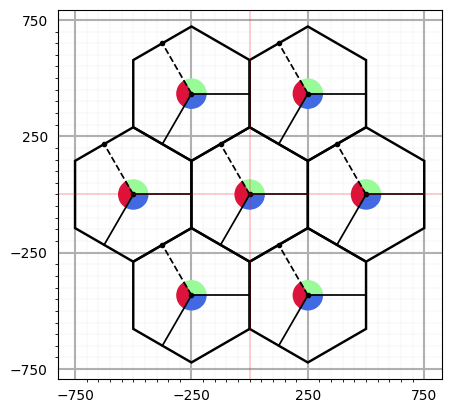

In [9]:
# Layout Parameters
isd                  = 500         # inter site distance
minDist              = 35          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 25          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
nSectorsPerSite      = 3           # number of sectors per site

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = nBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt,
                                UEheightDistribution="equal",
                                UEdistibution="equal",
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = UEroute) 

simLayoutObj(terrain = propTerrain,
             carrierFreq = carrierFrequency, 
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray)

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Simulation Topology")
ax.legend()

## Generate Channel Parameters

* This subsection provides the steps to obtain all the cluster level channel parameters, which includes both `Large Scale Parameters (LSPs)`
  and `Small Scale Parameters (SSPs)`. 
* LSPs includes `Path Loss (PL)`, `Delay Spread (DS)` and `Angular Spreads` both in Azimuth and Zenith directions,
  and `cluster powers (Pn)` comes under SSPs.
  
- LSPs/SSPs: paramGenObj.x where x is
    - ``linkStateVec``
    - ``delaySpread``
    - ``phiAoA_LoS``, ``phiAoA_mn``, ``phiAoA_spread``
    - ``thetaAoA_LoS``, ``thetaAoA_mn``, ``thetaAoA_spread``
    - ``phiAoD_LoS``, ``phiAoD_mn``, ``phiAoD_spread``
    - ``thetaAoD_LoS``, ``thetaAoD_mn``, ``thetaAoD_spread``
    - ``xpr``
    - ``pathloss``, ``pathDelay``, ``pathPower``
    - ``shadowFading``

In [10]:
# channel parameters
paramGenObj = simLayoutObj.getParameterGenerator()

[Warning]: Pathloss model for UMa is defined only for  2D distances 'd2D' between 10m and 5Km! Some distances are from outside this interval!
Ignoring for now but might result in unexpected behaviour!
[Warning]: Pathloss model for UMa is defined only for  2D distances 'd2D' between 10m and 5Km! Some distances are from outside this interval!
Ignoring for now but might result in unexpected behaviour!


## Generate Channel Coefficients

Cluster level channel coefficients can be simulated using the following code snippet.

 - ``channel.coefficients`` with shape: `(number of carrier frequencies, number of snapshots, number of BSs, number of UEs, numCluster/numPaths, number of Rx antennas, number of Tx antennas)`
 - ``channel.delays`` with shape: `(number of carrier frequencies, number of snapshots, number of BSs, number of UEs, numCluster/numPaths)`


In [ ]:
channel = paramGenObj.getChannel(applyPathLoss = True)

## Generate OFDM Channel

- Shape of OFDM Channel:
    - `Hf` is of shape : ``(number of carrier frequencies, number of snapshots, number of BSs, number of UEs, fftsize, number of Rx antennas, number of Tx antennas)``

In [ ]:
fftsize           = 512
subcarrierSpacing = 15*10**3
Hf = channel.ofdm(subcarrierSpacing, fftsize, simLayoutObj.carrierFrequency)
# Hf.shape: (numCarrierFrequencies, numSnapShots, numBSs, numUEs, Nfft, numRxAntennas, numTxAntennas)

### Frequency Domain : Magnitude Response Plot

* The frequency domain magnitude plots (frequency responses) helps demonstate the order of frequency selectivity
    - Frequency selectivity is low for LOS Channel
    - frequency selectivity is high for NLOS Channels
    
* Wireless channel at high frequency
    - has higher path-loss
    - less frequency selective (due to lower delay spread and weak distance paths)
    


In [ ]:
scaleFig = 1.5
fig, ax = plt.subplots(1,2,figsize=(17.5/scaleFig,7.5/scaleFig))
i = 0
ax[0].plot(np.arange(-channel.fftSize/2, channel.fftSize/2)*channel.subCarrierSpacing + channel.fc[0], 
           np.abs(Hf[0,0,0,i,:,0,0]), "g", label = "$f_c$="+str(channel.fc[0]/10**9)+" GHz")

ax[1].plot(np.arange(-channel.fftSize/2, channel.fftSize/2)*channel.subCarrierSpacing + channel.fc[1], 
           np.abs(Hf[1,0,0,i,:,0,0]), "g", label = "$f_c$="+str(channel.fc[1]/10**9)+" GHz")

ax[0].legend()
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Magnitude Response")
ax[0].grid()
ax[1].legend()
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Magnitude Response")
ax[1].grid()
fig.suptitle("Channel Frequency Response at Different Carrier Frequencies")

# plt.show()

### Time Domain Channel response

- Practical wireless channel are bandlimited which results in:
    - impulses widening:
        - higher for lower frequency channels
    - time spread
    
These effects can be observed in following plots.

In [ ]:
ht = np.fft.ifft(Hf, fftsize, axis = -3)

In [ ]:
scaleFig = 2
fig, ax = plt.subplots(2,1,figsize=(17.5/scaleFig,17.5/scaleFig))
i = 0
ax[0].stem(channel.delays[0,0,0,i], np.abs(channel.coefficients[0,0,0,i,:,0,0]), "r", label = "Ideal Channel")
ax[0].stem(np.arange(fftsize)/(fftsize*channel.subCarrierSpacing), np.abs(ht[0,0,0,i,:,0,0]), "g", label = "Practical Channel")
ax[0].legend()
ax[0].set_xlim([0, 0.4*10**-5])
ax[0].set_xlabel("delays (s)")
ax[0].set_ylabel("Power")
ax[0].grid()

ax[1].stem(channel.delays[1,0,0,i], np.abs(channel.coefficients[1,0,0,i,:,0,0]), "r", label = "Ideal Channel")
ax[1].stem(np.arange(fftsize)/(fftsize*channel.subCarrierSpacing), np.abs(ht[1,0,0,i,:,0,0]), "g", label = "Practical Channel")
ax[1].legend()
ax[1].set_xlim([0, 0.4*10**-5])
ax[1].set_xlabel("delays (s)")
ax[1].set_ylabel("Power")
ax[1].grid()

fig.suptitle("Power Delay Profile for the Different Carrier Frequencies")
plt.show()